In [59]:
import os
import sys

In [60]:
# Add the parent directory to the system path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))

In [61]:
import numpy as np
import matplotlib.pyplot as plt
from decimal import Decimal, ROUND_HALF_UP
from four_tanks import simulate

In [76]:
T = 1400
T_s = 1
time = np.arange(0, T+1, T_s)
T = max(time)
n_sampl = T//T_s+1
tau_u = 0
tau_y = 0
# x0 = [0.65, 0.66, 0.65, 0.66]
x0 = [12.4, 1.8, 12.7, 1.4]
# x0 = [12.6, 4.8, 13, 4.9]
active_noise = False # wartość False wyłącza zakłócenia, wartość True włącza
noise_sigma = 0.1
e_sigma = 0.005

In [77]:
# cm
qa = 3*3.33 # 3.15*3.14 #3*3.33
qb = 3*3.35 # 3.15*3.29 #3*3.35
q = np.vstack((np.ones((1, n_sampl))* qa, np.ones((1, n_sampl))* qb))
x_max = np.inf
x_min = -np.inf
gamma_a = 0.7
gamma_b = 0.6
S = np.array([28, 32, 28, 32])
a = np.array([0.071, 0.057, 0.071, 0.057]) # przekrój otworu wylotowego
c = np.array([0.5, 0.5, 0.5, 0.5])

In [78]:
# qa = 1630000/3600
# qb = 2000000/3600
# q = np.vstack((np.ones((1, n_sampl))* qa, np.ones((1, n_sampl))* qb))
# x_max = np.inf
# x_min = -np.inf
# gamma_a = 0.3
# gamma_b = 0.4
# S = np.array([60, 60, 60, 60])
# a = np.array([1.31, 1.51, 0.927, 0.882]) # przekrój otworu wylotowego
# c = np.array([0.5, 0.5, 0.5, 0.5])a


In [66]:
x, y, z = simulate(x0, x_max, x_min, gamma_a, gamma_b, S, a, c, q, T, T_s, tau_u, tau_y, active_noise, noise_sigma, e_sigma)

In [67]:
x

array([[ 12.4       ,  12.64975   ,  12.8995    , ..., 361.5505    ,
        361.80025   , 362.05      ],
       [  1.8       ,   1.9884375 ,   2.176875  , ..., 265.235625  ,
        265.4240625 , 265.6125    ],
       [ 12.7       ,  12.44330268,  12.19067121, ...,   1.63394113,
          1.63394113,   1.63394113],
       [  1.4       ,   1.40030108,   1.40059211, ...,   1.4090447 ,
          1.4090447 ,   1.4090447 ]])

In [68]:
title_end = f" dla $x_0$={x0}, $\gamma_a$={gamma_a}, $\gamma_b$={gamma_b}"

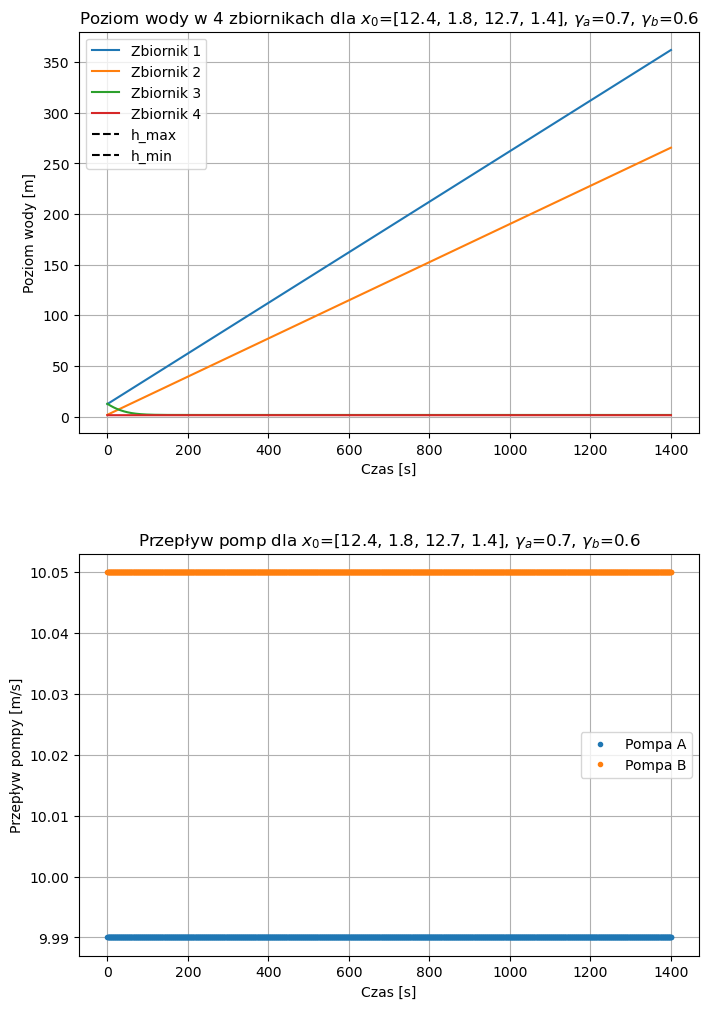

In [69]:
fig2=plt.figure(figsize=(8, 12))
plt.subplot(2, 1, 1)
plt.plot(time, x[0], label='Zbiornik 1')
plt.plot(time, x[1], label='Zbiornik 2')
plt.plot(time, x[2], label='Zbiornik 3')
plt.plot(time, x[3], label='Zbiornik 4')
plt.axhline(y=x_max, color='black', linestyle='--', label='h_max')
plt.axhline(y=x_min, color='black', linestyle='--', label='h_min')
plt.xlabel('Czas [s]')
plt.ylabel('Poziom wody [m]')
plt.title("Poziom wody w 4 zbiornikach"+title_end)
plt.legend()
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(time, q[0], '.', label='Pompa A')
plt.plot(time, q[1], '.', label='Pompa B')
plt.xlabel('Czas [s]')
plt.ylabel('Przepływ pompy [m/s]')
plt.title('Przepływ pomp'+title_end)
plt.legend()
plt.grid()

plt.subplots_adjust(hspace=0.3)

In [139]:
g = 981

n_sampl = T//T_s+1
p = np.reshape(a/S * np.sqrt(2*g), (4, -1))

A = np.array(
[[-1, 0, 1, 0],
    [0, -1, 0, 1],
    [0, 0, -1, 0],
    [0, 0, 0, -1]])

B = np.array(
    [[gamma_a/S[0], 0],
    [0, gamma_b/S[1]],
    [0, (1-gamma_b)/S[2]],
    [(1-gamma_a)/S[3], 0]])

C = np.array(
    [[c[0], 0, 0, 0],
    [0, c[1], 0, 0],
    [0, 0, c[2], 0],
    [0, 0, 0, c[3]]])

F = np.array(
    [[1, 0, 0, 0],
    [0, 1, 0, 0]])

x = np.ones((4, n_sampl))
for i in range(len(x0)):
    x[i, 0:max(tau_u, tau_y, 1)] = x0[i]
dx = np.ones((4, n_sampl))
for i in range(len(x0)):
    dx[i, 0:max(tau_u, tau_y, 1)] = x0[i]
y = np.empty((4, n_sampl))
z = F @ x

for t in range(max(tau_u, tau_y, 1), n_sampl):
    dx[:, [t]] = T_s * (A @ (p * np.sqrt(x[:, [t-1]])) + B @ q[:, [t-tau_u]] + np.random.randn(4,1)*noise_sigma*active_noise)
    x[:, [t]] = x[:, [t-1]] + dx[:, [t]]
    x[:, t] = np.clip(x[:, t], x_min, x_max)
    y[:, [t]] = C @ x[:, [t-tau_y]] + np.random.randn(4,1)*e_sigma*active_noise
    z[:, [t]] = F @ x[:, [t]]

In [140]:
x

array([[12.4       , 12.65450584, 12.90090756, ..., 12.26296752,
        12.26296752, 12.26296752],
       [ 1.8       ,  1.97593786,  2.14683304, ..., 12.78315684,
        12.78315685, 12.78315687],
       [12.7       , 12.44330268, 12.19067121, ...,  1.63394113,
         1.63394113,  1.63394113],
       [ 1.4       ,  1.40030108,  1.40059211, ...,  1.4090447 ,
         1.4090447 ,  1.4090447 ]])

In [135]:
dx

array([[ 1.24000000e+01,  2.49750000e-01,  2.49750000e-01, ...,
         2.49750000e-01,  2.49750000e-01,  2.49750000e-01],
       [ 1.80000000e+00,  1.88437500e-01,  1.88437500e-01, ...,
         1.88437500e-01,  1.88437500e-01,  1.88437500e-01],
       [ 1.27000000e+01, -2.56697316e-01, -2.52631473e-01, ...,
        -1.11022302e-16, -1.11022302e-16, -1.11022302e-16],
       [ 1.40000000e+00,  3.01075147e-04,  2.91037500e-04, ...,
         1.11022302e-16,  1.11022302e-16,  1.11022302e-16]])